Correlate similarity of multiple ligands for the same target

Choose targets that are quite common

e.g carbonic anhydrase inhibitors, etc.

In [1]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [68]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset, PDBBindBenchmark, DynamicBatchWrapper
from data.atom3d_dataset import LBADataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from models import DenoisePretrainModel, AffinityPredictor
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import itertools
import random
import scipy

In [3]:
def get_tanimoto_similarity(pdb1, pdb2):
    # Load molecules from Mol2 files
    mol1 = Chem.MolFromMol2File(f"/n/holyscratch01/mzitnik_lab/afang/data/pdbbind/PDBbind_v2020_PL_refined/refined-set/{pdb1}/{pdb1}_ligand.mol2")
    mol2 = Chem.MolFromMol2File(f"/n/holyscratch01/mzitnik_lab/afang/data/pdbbind/PDBbind_v2020_PL_refined/refined-set/{pdb2}/{pdb2}_ligand.mol2")

    # Generate fingerprints (e.g., Morgan fingerprints with radius 2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)

    # Calculate Tanimoto similarity
    tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    return tanimoto_similarity

In [4]:
dataset = LBADataset("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train")

fragmentation False
2024-02-18 11:32:02::INFO::Loading preprocessed data from /n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train.LBADataset_processed.pkl...


In [5]:
with open("carbonic_anhydrase_2.txt", "r") as f:
    proteins = f.read().split("\n")
len(set(proteins))

277

In [6]:
# given a list of pdb files get the chain using BioPython
from Bio.PDB import PDBParser
from collections import defaultdict

def get_pdb_path(pdb_id):
    return f"/n/holyscratch01/mzitnik_lab/afang/data/pdbbind/PDBbind_v2020_PL_refined/refined-set/{pdb_id}/{pdb_id}_pocket.pdb"

chains = defaultdict(list)
for pdbid in proteins:
    parser = PDBParser()
    structure = parser.get_structure("test", get_pdb_path(pdbid))
    chain = [ch.id for ch in structure.get_chains()][0]
    chains[chain].append(pdbid)

for k, v in chains.items():
    print(k, len(v))

proteins = chains["A"]

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 311
  warnings.warn(
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 203
  warnings.warn(
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 235
  warnings.warn(


A 264
B 12
X 1


In [7]:
protein_dataset = []
for d in dataset:
    if d["id"] not in proteins:
        continue
    protein_dataset.append(d)
len(protein_dataset)

264

In [58]:
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_112/checkpoint/epoch144_step61190.ckpt"

# "/n/holyscratch01/mzitnik_lab/afang/GET/pretrain/models/InteractNN-global/version_76/checkpoint/epoch8_step690593.ckpt" # pretrained only
# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_104/checkpoint/epoch129_step54860.ckpt" # partial finetuned from the 4 day long pretraining run with global nodes
# "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_98/checkpoint/epoch109_step46420.ckpt" # finetuned from the 4 day long pretraining run
# "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_89/checkpoint/epoch69_step29470.ckpt" # finetuned from QBioLIP
model = torch.load(pretrain_ckpt, map_location='cpu')
model = model.to("cuda")

In [59]:
embeddings = {}
ligand_embeddings = {}
pocket_embeddings = {}
pred_labels = {}
true_labels = {}
batch_size = 8
for i in range(0, len(protein_dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(protein_dataset[i:i+batch_size])
        pdb_ids = [d["id"] for d in protein_dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()
            ligand_embeddings[pdb_id] = output.block_repr[torch.logical_and(batch_id == idx, minibatch["segment_ids"] == 1)].cpu().numpy().mean(axis=0)
            pocket_embeddings[pdb_id] = output.block_repr[torch.logical_and(batch_id == idx, minibatch["segment_ids"] == 0)].cpu().numpy().mean(axis=0)
            pred_labels[pdb_id] = pred_binding_affinity[idx].cpu().numpy() if pred_binding_affinity[idx] is not None else None
            true_labels[pdb_id] = minibatch["label"][idx].cpu().numpy()

Note these proteins are part of the training set

In [42]:
error = np.array([np.abs(pred_labels[k] - true_labels[k]) for k in proteins])
error.mean()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [50]:
pairs = list(itertools.combinations(proteins, 2))
subsample_pairs = random.sample(pairs, 500)

In [51]:
tani_similarities = []
for p1, p2 in subsample_pairs:
    tani = get_tanimoto_similarity(p1, p2)
    tani_similarities.append(tani)

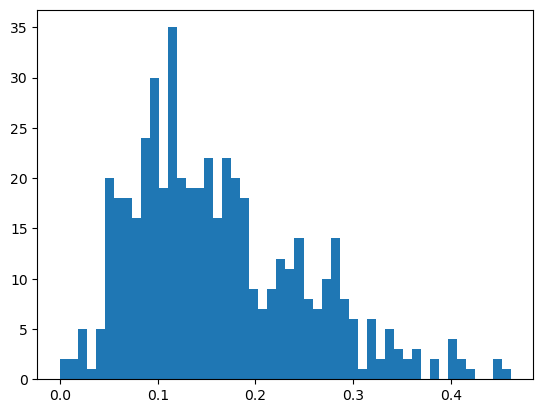

In [52]:
plt.hist(tani_similarities, bins=50)
plt.show()

# How does distance in the embedding space correlate to distance in the chemical space? 
For HIV protease inhibitors, we will use the Tanimoto similarity to calculate the similarity between ligands.

correlation coeff: 0.25475039584710873


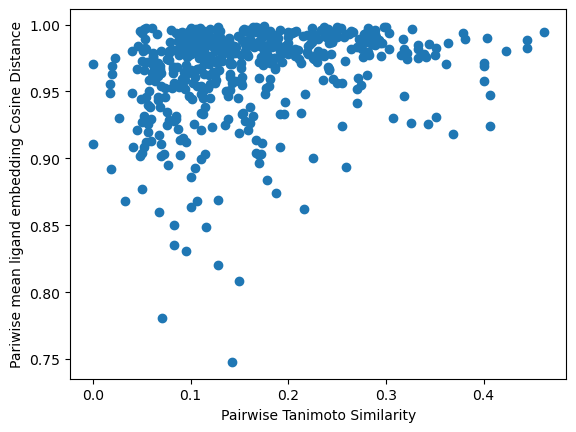

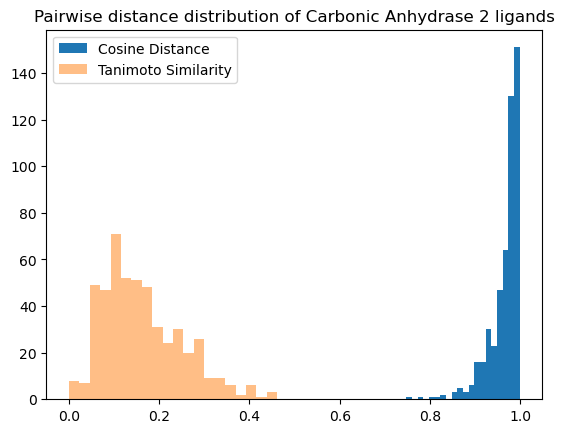

In [70]:
select_embeddings = ligand_embeddings

dsim_similarities = []
for p1, p2 in subsample_pairs:
    dsim = np.dot(select_embeddings[p1], select_embeddings[p2]) / (np.linalg.norm(select_embeddings[p1]) * np.linalg.norm(select_embeddings[p2]))
    dsim_similarities.append(dsim)
plt.scatter(tani_similarities, dsim_similarities)
plt.xlabel("Pairwise Tanimoto Similarity")
plt.ylabel("Pariwise mean ligand embedding Cosine Distance")
print(f"correlation coeff: {np.corrcoef(tani_similarities, dsim_similarities)[0][1]}")
plt.show()

plt.hist(dsim_similarities, bins=20, label = "Cosine Distance")
plt.hist(tani_similarities, bins=20, alpha=0.5, label = "Tanimoto Similarity")
plt.legend()
plt.title("Pairwise distance distribution of Carbonic Anhydrase 2 ligands")
plt.show()

Higher cosine similarity in embedding space = higher Tanimoto similarity

correlation coeff: -0.27866931801166034


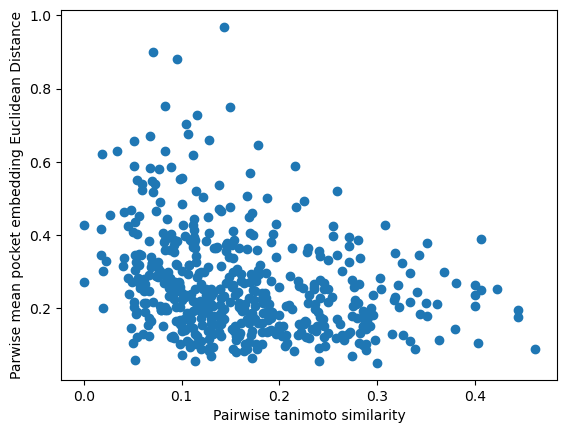

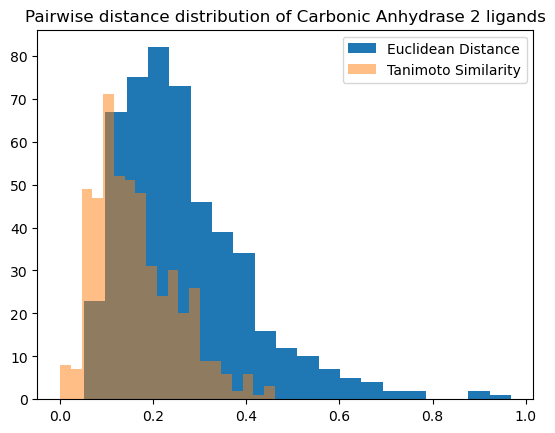

In [71]:
dsim_similarities = []
for p1, p2 in subsample_pairs:
    dsim = np.linalg.norm(embeddings[p1] - embeddings[p2])
    dsim_similarities.append(dsim)
plt.scatter(tani_similarities, dsim_similarities)
plt.xlabel("Pairwise tanimoto similarity")
plt.ylabel("Parwise mean pocket embedding Euclidean Distance")
print(f"correlation coeff: {np.corrcoef(tani_similarities, dsim_similarities)[0][1]}")
plt.show()

plt.hist(dsim_similarities, bins=20, label = "Euclidean Distance")
plt.hist(tani_similarities, bins=20, alpha=0.5, label = "Tanimoto Similarity")
plt.legend()
plt.title("Pairwise distance distribution of Carbonic Anhydrase 2 ligands")
plt.show()

Lower Euclidean distance (more similar graph embeddings) = higher Tanimoto similarity

# How does distance in the chemical space correlate to binding affinity? 
For HIV protease inhibitors, we will use the Tanimoto similarity to calculate the similarity between ligands.

correlation coeff: -0.2736826985833261


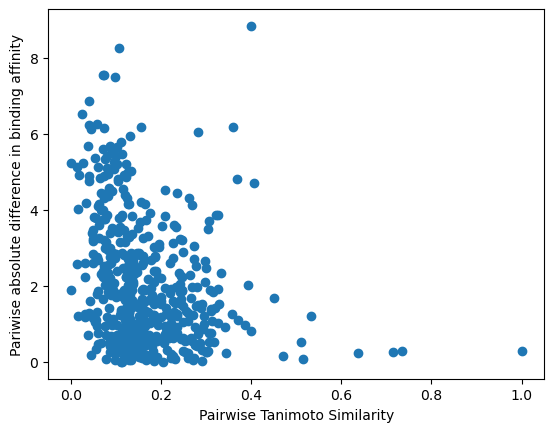

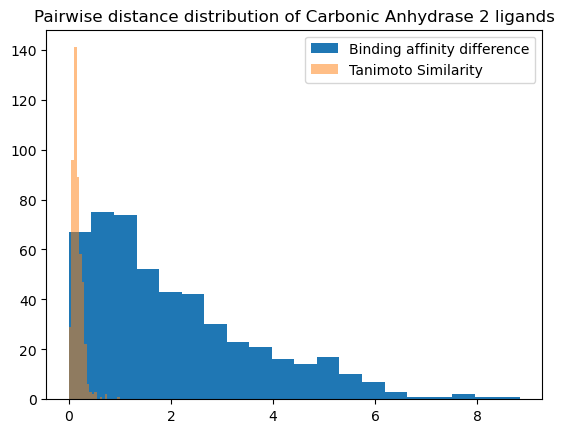

In [13]:
dsim_similarities = []
for p1, p2 in subsample_pairs:
    dsim = np.absolute(true_labels[p1] - true_labels[p2])
    dsim_similarities.append(dsim)
plt.scatter(tani_similarities, dsim_similarities)
plt.xlabel("Pairwise Tanimoto Similarity")
plt.ylabel("Pariwise absolute difference in binding affinity")
print(f"correlation coeff: {np.corrcoef(tani_similarities, dsim_similarities)[0][1]}")
plt.show()

plt.hist(dsim_similarities, bins=20, label = "Binding affinity difference")
plt.hist(tani_similarities, bins=20, alpha=0.5, label = "Tanimoto Similarity")
plt.legend()
plt.title("Pairwise distance distribution of Carbonic Anhydrase 2 ligands")
plt.show()

# How similar are the embeddings of complementary ligands and pockets?

In [65]:
rand_prot_lig_distance = []
same_prot_lig_distance = []
for pdb_id1, pdb_id2 in subsample_pairs:
    rand_prot_lig_distance.append(np.linalg.norm(ligand_embeddings[pdb_id1] - pocket_embeddings[pdb_id2]))
    rand_prot_lig_distance.append(np.linalg.norm(ligand_embeddings[pdb_id2] - pocket_embeddings[pdb_id1]))
    same_prot_lig_distance.append(np.linalg.norm(ligand_embeddings[pdb_id1] - pocket_embeddings[pdb_id1]))
    same_prot_lig_distance.append(np.linalg.norm(ligand_embeddings[pdb_id2] - pocket_embeddings[pdb_id2]))

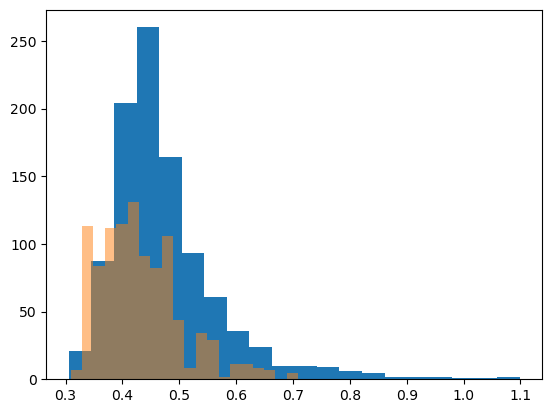

In [67]:
plt.hist(rand_prot_lig_distance, bins=20, label = "Random protein-ligand distance")
plt.hist(same_prot_lig_distance, bins=20, alpha=0.5, label = "Same protein-ligand distance")
plt.show()

In [69]:
scipy.stats.ks_2samp(rand_prot_lig_distance, same_prot_lig_distance)

KstestResult(statistic=0.237, pvalue=4.853305934225328e-25, statistic_location=0.42720786, statistic_sign=-1)